In [1]:
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torchvision.transforms.functional as TF
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

In [2]:
print(os.listdir("../input/dlp-object-detection/final_dlp_data/final_dlp_data/train"))

['labels', 'images']


In [3]:
transform = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor()
        ])
a = Image.open('/kaggle/input/dlp-object-detection/final_dlp_data/final_dlp_data/train/images/008b8a9c-dae2-4a58-accf-33165472de6e.jpeg').convert("RGB")
a = transform(a)
a.shape

torch.Size([3, 512, 512])

In [4]:
classes = {
"aegypti": 0,
"albopictus": 1,
"anopheles": 2,
"culex": 3,
"culiseta": 4,
"japonicus": 5,
"koreicus": 5
}

def get_mod_label(label):
    one_hot_enc = np.zeros(5)
    remaining = label[1:]
    one_hot_enc[int(label[0])-1] = 1
    print(np.concatenate((one_hot_enc, remaining), axis=0))
    return np.concatenate((one_hot_enc, remaining), axis=0)

    
class MosquitoDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor()
        ])
        self.images = os.listdir(image_dir)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx].replace(".jpeg", ".txt"))
        with open(label_path, 'r') as file:
            label = [line.strip().split(" ") for line in file]
            label = [float(x) for x in label[0]]
        image = Image.open(img_path).convert("RGB")
        
        return self.transform(image), get_mod_label(label)
            

In [5]:
classes

{'aegypti': 0,
 'albopictus': 1,
 'anopheles': 2,
 'culex': 3,
 'culiseta': 4,
 'japonicus': 5,
 'koreicus': 5}

In [6]:
DATASET_DIR = '../input/dlp-object-detection/final_dlp_data/final_dlp_data/train/'


In [7]:
train_dataset = MosquitoDataset(DATASET_DIR+'images', DATASET_DIR+'labels')

In [8]:
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2])

[0.         0.         1.         0.         0.         0.46393897
 0.46821036 0.39944521 0.26766091]
(tensor([[[0.6431, 0.6431, 0.6431,  ..., 0.6667, 0.6549, 0.6588],
         [0.6471, 0.6392, 0.6392,  ..., 0.6667, 0.6627, 0.6627],
         [0.6392, 0.6392, 0.6392,  ..., 0.6706, 0.6745, 0.6745],
         ...,
         [0.6314, 0.6275, 0.6235,  ..., 0.6980, 0.6902, 0.6902],
         [0.6353, 0.6275, 0.6314,  ..., 0.6902, 0.6941, 0.6902],
         [0.6314, 0.6275, 0.6314,  ..., 0.6863, 0.6941, 0.6941]],

        [[0.6392, 0.6392, 0.6392,  ..., 0.6549, 0.6431, 0.6471],
         [0.6431, 0.6353, 0.6314,  ..., 0.6549, 0.6510, 0.6510],
         [0.6353, 0.6353, 0.6353,  ..., 0.6588, 0.6627, 0.6627],
         ...,
         [0.6196, 0.6157, 0.6118,  ..., 0.6784, 0.6706, 0.6745],
         [0.6235, 0.6157, 0.6196,  ..., 0.6706, 0.6745, 0.6745],
         [0.6196, 0.6157, 0.6196,  ..., 0.6667, 0.6745, 0.6784]],

        [[0.6235, 0.6235, 0.6196,  ..., 0.6353, 0.6235, 0.6275],
         [0.6235, 0.

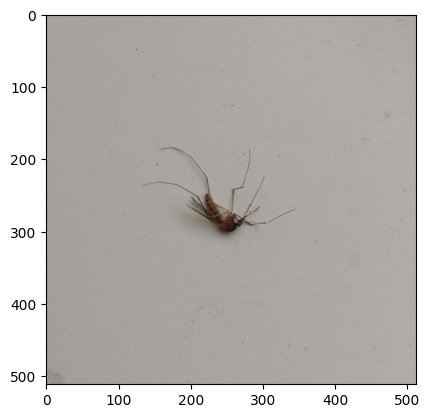

In [9]:
img = train_dataset[0]
print(img)
imgPIL = img[0].permute(1,2,0)
imgPIL.size()
plt.imshow(imgPIL.numpy())

In [10]:
os.cpu_count()


4

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    NUM_WORKERS = torch.cuda.device_count() * min(4, os.cpu_count())
else: 
    NUM_WORKERS = min(4, os.cpu_count())

In [12]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 8
PIN_MEMORY = False
SHUFFLE = True

In [13]:
from functools import partial

setup_dataloader = partial(DataLoader, 
                           num_workers=NUM_WORKERS,
                           pin_memory=PIN_MEMORY,
                           batch_size=BATCH_SIZE,
                           shuffle=SHUFFLE
                          )

In [14]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, filter_size):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, filter_size, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)
        
class YOLO(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(YOLO, self).__init__()
        self.net = nn.Sequential(
            ConvBlock(in_channel, 4, 3),
            ConvBlock(4, 8, 3),
            ConvBlock(8, 16, 5),
            ConvBlock(16, 8, 5),
            ConvBlock(8, 4, 3),
        )
    def forward(self, x):
        return self.net(x)
        

In [15]:
model = YOLO(3, 1)
model

YOLO(
  (net): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (3): ConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
        (1):

In [16]:
def test():
    inp = torch.randn((10, 3, 512, 512))
    model = YOLO(3, 1)
    out = model(inp)
    print(inp.shape)
    print(out.shape)

test()

torch.Size([10, 3, 512, 512])
torch.Size([10, 4, 508, 508])


In [17]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()